# Object Tracking in videos

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

## Utils

In [2]:
def get_rectangle(frame):
    # Define a variable to store the coordinates of the rectangle
    rect = [0, 0, 0, 0]
    
    # Make a copy of the frame
    img = frame.copy()
    
    # Define the mouse callback function
    def select_rectangle(event, x, y, flags, param):
        nonlocal rect
        if event == cv2.EVENT_LBUTTONDOWN:
            rect[0] = x
            rect[1] = y
        elif event == cv2.EVENT_LBUTTONUP:
            rect[2] = x - rect[0]
            rect[3] = y - rect[1]

    # Set the mouse callback function for the window
    cv2.namedWindow("Select rectangle")
    cv2.setMouseCallback("Select rectangle", select_rectangle)
    # draw rectangle
    
    
    while(True):
        # Show the frame
        cv2.rectangle(img, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (0, 255, 0), 2)
        cv2.imshow("Select rectangle", img)

        # Exit if the user presses the 'q' key
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the display window
    cv2.destroyAllWindows()
    
    return rect



In [3]:
def play_video(frames):
    """
    Play a video from a list of frames
    """

    print("Playing video ....")
    print("Press q to exit")
    for i in range(frames.shape[-1]):
        cv2.imshow('frame', frames[...,i])
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
    cv2.destroyAllWindows()


In [4]:
def play_video_list(frames):
    """
    Play a video from a list of frames
    """

    print("Playing video ....")
    print("Press q to exit")
    for i in range(len(frames)):
        cv2.imshow('frame', frames[i])
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
    cv2.destroyAllWindows()

In [5]:
# transforming perspective of a set of points using homography
def transformPerspectivePts(pts, M):
    """
    This function transforms a list of points using a given homography matrix
    params:
        pts: the coordinates of source points
        M: homography matrix used for transformation
    returns:
        pts_transformed: the coordinates of the destination points
    """
    warp_mat = np.array([[1+M[0], M[2], M[4]], [M[1], 1+M[3], M[5]], [0, 0, 1]])
    pts_transformed = []
    for pt in pts:
        p = np.array([pt[0], pt[1], 1])
        p_dash = np.dot(warp_mat, p)
        x_dash, y_dash = int(p_dash[0]/p_dash[2]), int(p_dash[1]/p_dash[2])
        pts_transformed.append([x_dash, y_dash])
    
    return pts_transformed

In [6]:
# transforming perspective of an image using homography
def transformPerspectiveImage(img_src, M, dst_shape):
    """
    This function warps an image using a given homography matrix
    params:
        img_src: the image to be warped
        M: homography matrix used for transformation
        dst_shape: the dimensions of the destination frame
    returns:
        warped_image: the resulting image from the transformation
    """
    dst_shapeX, dst_shapeY = dst_shape
    warped_image = np.zeros((dst_shapeY, dst_shapeX, 3), dtype='uint8')
    
    for y in range(img_src.shape[0]):
        for x in range(img_src.shape[1]):
            p = np.array([x,y,1])
            p_dash = np.dot(M, p)
            x_dash, y_dash = (p_dash[0]/p_dash[2]), (p_dash[1]/p_dash[2])

            if 0 < y_dash+1 < warped_image.shape[0] and 0 < x_dash+1 < warped_image.shape[1]:
                warped_image[int(y_dash), int(x_dash), :] = img_src[y, x, :]
    
    return warped_image

In [7]:
def getCornerPts(components):
    x, y, w, h = components
    return np.array([[x, y], [x+w, y], [x, y+h], [x+w, y+h]], dtype='int16')

In [8]:
def getRectComponents(corner_pts):
    x, y = corner_pts[0][0], corner_pts[0][1]
    w = corner_pts[3][0] - x
    h = corner_pts[3][1] - y
    return x, y, w, h

## Loading Data

In [9]:
data_dir = '../Data/'

car_1 = np.load(data_dir + "car1.npy")
car_2 = np.load(data_dir + "car2.npy")
landing = np.load(data_dir + "landing.npy")

In [17]:
play_video(car_1)

Playing video ....
Press q to exit


In [11]:
rect = get_rectangle(car_1[:,:,0])
rect

[95, 95, 264, 197]

## LK Tracker Implementation

In [10]:
def crop(img, roi):
    return img[roi[0][1]:roi[1][1], roi[0][0]:roi[1][0]]

In [11]:
def jacobian(x_shape, y_shape):
    # get jacobian of the template size.
    x = np.array(range(x_shape))
    y = np.array(range(y_shape))
    x, y = np.meshgrid(x, y) 
    ones = np.ones((y_shape, x_shape))
    zeros = np.zeros((y_shape, x_shape))

    row1 = np.stack((x, zeros, y, zeros, ones, zeros), axis=2)
    row2 = np.stack((zeros, x, zeros, y, zeros, ones), axis=2)
    jacob = np.stack((row1, row2), axis=2)

    return jacob

In [12]:
def affineLKtracker(img, template, rect, p, threshold, check_brightness, max_iter=100):
        d_p_norm = np.inf
        
        template = crop(template, rect)
        rows, cols = template.shape
        
        #img = (img-np.mean(img))/np.std(img)
        p_prev = p
        iter = 0
        while (d_p_norm >= threshold) and iter <= max_iter:
            warp_mat = np.array([[1+p_prev[0], p_prev[2], p_prev[4]], [p_prev[1], 1+p_prev[3], p_prev[5]]])
           
            
            warp_img = crop(cv2.warpAffine(img, warp_mat, (img.shape[1],img.shape[0]),flags=cv2.INTER_CUBIC), rect)
                
            diff = template.astype(int) - warp_img.astype(int)
        
            # Calculate warp gradient of image
            grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
            grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
            
            #warp the gradient
            grad_x_warp = crop(cv2.warpAffine(grad_x, warp_mat, (img.shape[1],img.shape[0]),flags=cv2.INTER_CUBIC+cv2.WARP_INVERSE_MAP), rect)
            grad_y_warp = crop(cv2.warpAffine(grad_y, warp_mat, (img.shape[1],img.shape[0]),flags=cv2.INTER_CUBIC+cv2.WARP_INVERSE_MAP), rect)
            
            
            
            # Calculate Jacobian for the 
            jacob = jacobian(cols, rows)
            
            grad = np.stack((grad_x_warp, grad_y_warp), axis=2)
            grad = np.expand_dims((grad), axis=2)
            
            #calculate steepest descent
            steepest_descents = np.matmul(grad, jacob)
            steepest_descents_trans = np.transpose(steepest_descents, (0, 1, 3, 2))
            
            # Compute Hessian matrix
            hessian_matrix = np.matmul(steepest_descents_trans, steepest_descents).sum((0,1))
         
            # Compute steepest-gradient-descent update
            diff = diff.reshape((rows, cols, 1, 1))
            update = (steepest_descents_trans * diff).sum((0,1))
            
            # calculate dp and update it
            d_p = np.matmul(np.linalg.pinv(hessian_matrix), update).reshape((-1))
                
            p_prev += d_p
            
            d_p_norm = np.linalg.norm(d_p)
            iter += 1
            
        return p_prev


## Testing

### Single Frame

In [ ]:
# p = np.zeros(6)
# threshold = 0.001

# rect = [95, 95, 264, 197]
# warp_mat = affineLKtracker(car_1[...,1], car_1[...,0], rect, p, threshold, 0, max_iter=100)
# warp_mat

### Video

In [ ]:
# p = np.zeros(6)
# threshold = 0.001
# rect = [95, 95, 264, 197]

# roi = np.array([[95, 95], [359, 292]])
# rect_tl_pt = np.array([roi[0][0], roi[0][1], 1])
# rect_br_pt = np.array([roi[1][0], roi[1][1], 1])

# corners = []
# corners.append(rect)

# for i in range(1, car_1.shape[-1]):
#     p = affineLKtracker(car_1[...,i], car_1[...,i-1], corners[i-1], p, threshold, 0, max_iter=100)
#     warp_mat = np.array([[1 + p[0], p[2], p[4]], [p[1], 1 + p[3], p[5]]])
#     corner_pts = getCornerPts(corners[i-1])
#     # transformed_corner_pts = transformPerspectivePts(corner_pts, warp_mat)
#     # w = np.array([[1+warp_mat[0], warp_mat[2], warp_mat[4]], [warp_mat[1], 1+warp_mat[3], warp_mat[5]], [0, 0, 1]])
#     transformed_corner_pts = cv2.warpAffine(corner_pts, warp_mat, (corners[i-1][2],corners[i-1][3]), flags=cv2.INTER_CUBIC+cv2.WARP_INVERSE_MAP)
#     corners.append(getRectComponents(transformed_corner_pts))
    

In [ ]:
# video_corners = np.empty((car_1.shape[0], car_1.shape[1], car_1.shape[2]), dtype='uint8')
# video_corners = []
# for i in range(len(corners)):
#     # video_corners[...,i] = car_1[...,i].copy()
#     video_corners.append(car_1[...,i].copy())
#     cv2.rectangle(video_corners[i], (corners[i][0], corners[i][1]), (corners[i][0] + corners[i][2], corners[i][1] + corners[i][3]), (0, 255, 0), 2)

In [14]:
p = np.zeros(6)
threshold = 0.001
rect = [95, 95, 264, 197]

roi = np.array([[95, 95], [359, 292]])
rect_tl_pt = np.array([roi[0][0], roi[0][1], 1])
rect_br_pt = np.array([roi[1][0], roi[1][1], 1])

video_corners = []
video_corners.append(car_1[...,0].copy())

for i in range(1, car_1.shape[-1]):
    video_corners.append(car_1[...,i].copy())
    p = affineLKtracker(video_corners[i], video_corners[i-1], roi, p, threshold, 0, max_iter=100)
    warp_mat = np.array([[1 + p[0], p[2], p[4]], [p[1], 1 + p[3], p[5]]])

    rect_tl_pt_new = (warp_mat @ rect_tl_pt).astype(int)
    rect_br_pt_new = (warp_mat @ rect_br_pt).astype(int)

    cv2.rectangle(video_corners[i], tuple(rect_tl_pt_new), tuple(rect_br_pt_new), (0, 0, 255), 2)

    roi = np.array([[rect_tl_pt_new[0], rect_tl_pt_new[1]], [rect_br_pt_new[0], rect_br_pt_new[1]]])
    rect_tl_pt = np.array([roi[0][0], roi[0][1], 1])
    rect_br_pt = np.array([roi[1][0], roi[1][1], 1])
    

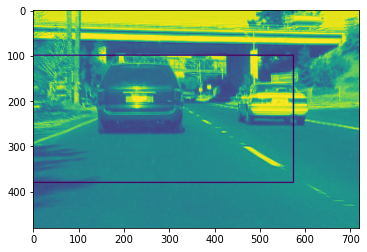

In [15]:
plt.imshow(video_corners[50])

In [16]:
play_video_list(video_corners)

Playing video ....
Press q to exit
